In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
import SimpleITK as sitk
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

# For reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()



In [158]:
# --- Image + Mask Paths ---
from glob import glob
image_paths = sorted(glob("image_mha/*.mha"))
mask_paths = sorted(glob("label_mha/*.mha"))

In [125]:
class PSFHSDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image and mask
        image = sitk.ReadImage(self.image_paths[idx])
        mask = sitk.ReadImage(self.mask_paths[idx])

        # Convert to NumPy arrays
        image_np = sitk.GetArrayFromImage(image)
        mask_np = sitk.GetArrayFromImage(mask)

        # If 3D, take middle slice
        if image_np.ndim == 3:
            image_np = image_np[image_np.shape[0] // 2]


        if mask_np.ndim == 3:
            mask_np = mask_np[mask_np.shape[0] // 2]

        if self.transform is None:
            # Normalize image [0, 1]
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
            image_np = image_np.astype(np.float32)

        # Add channel for Albumentations: [H, W, C]
        image_np = np.expand_dims(image_np, axis=-1)  # (H, W, 1)

        if self.transform:

            augmented = self.transform(image=image_np, mask=mask_np.astype(np.uint8))
            image_tensor = augmented["image"]
            mask_tensor = augmented["mask"].long()

        else:
            # Convert manually if no transform is provided
            image_tensor = torch.from_numpy(image_np.transpose(2, 0, 1))  # (1, H, W)
            mask_tensor = torch.from_numpy(mask_np).long()                # (H, W)

        return image_tensor, mask_tensor



In [130]:
def count_class_frequencies(mask_paths, num_classes=3):
    counts = np.zeros(num_classes, dtype=np.int64)
    for mask_path in mask_paths:
        mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
        # If 3D, take middle slice (same as your dataset code)
        if mask.ndim == 3:
            mask = mask[mask.shape[0] // 2]
        # Flatten and count occurrences
        for cls in range(num_classes):
            counts[cls] += np.sum(mask == cls)
    return counts

In [126]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.middle = DoubleConv(128, 256)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.middle(self.pool(x2))
        x = self.dec1(torch.cat([self.up1(x3), x2], dim=1))
        x = self.dec2(torch.cat([self.up2(x), x1], dim=1))
        return self.final(x)


In [127]:
def compute_dice(preds, targets, num_classes=3):
    preds = torch.argmax(F.softmax(preds, dim=1), dim=1)
    dice_scores = []
    for cls in range(1, num_classes):  # Skip background
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * intersection) / union if union > 0 else torch.tensor(1.0)
        dice_scores.append(dice.item())
    return sum(dice_scores) / len(dice_scores)

def compute_iou(preds, targets, num_classes=3):
    preds = torch.argmax(F.softmax(preds, dim=1), dim=1)
    iou_scores = []
    for cls in range(1, num_classes):  # Skip background
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection
        iou = intersection / union if union > 0 else torch.tensor(1.0)
        iou_scores.append(iou.item())
    return sum(iou_scores) / len(iou_scores)



In [128]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)  # (B, C, H, W)
        targets_onehot = F.one_hot(targets, num_classes=self.num_classes)  # (B, H, W, C)
        targets_onehot = targets_onehot.permute(0, 3, 1, 2).float()        # (B, C, H, W)

        dims = (0, 2, 3)
        intersection = torch.sum(probs * targets_onehot, dims)
        union = torch.sum(probs, dims) + torch.sum(targets_onehot, dims)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice
        # Only foreground classes
        return dice_loss[1:].mean()

class ComboLoss(nn.Module):
    def __init__(self, num_classes=3, dice_weight=0.7, ce_weight=0.3, ce_weights=None):
        super().__init__()
        self.dice = DiceLoss(num_classes)
        self.ce = nn.CrossEntropyLoss(weight=ce_weights)
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight

    def forward(self, logits, targets):
        dice = self.dice(logits, targets)
        ce = self.ce(logits, targets)
        return self.dice_weight * dice + self.ce_weight * ce


In [157]:

def run_training(transform=None, mode="No Augmentation", class_weights=None):
    print(f"\n--- Starting training: {mode} ---")
    dataset = PSFHSDataset(image_paths, mask_paths, transform=transform)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if class_weights is not None:
        class_weights = class_weights.to(device)  # move to device

    fold_dice_scores = []
    fold_iou_scores = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n--- Fold {fold+1} ---")

        train_loader = DataLoader(Subset(dataset, train_idx), batch_size=4, shuffle=True)
        val_loader = DataLoader(Subset(dataset, val_idx), batch_size=4)

        model = UNet().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = ComboLoss(num_classes=3, dice_weight=0.7, ce_weight=0.3, ce_weights=class_weights)

        best_dice = 0
        best_iou = 0

        for epoch in range(15):
            model.train()
            for imgs, masks in train_loader:
                # Just after loading a batch in train_loader and val_loader
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                if masks.ndim == 4:
                    masks = masks.squeeze(1)
                loss = criterion(preds, masks)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation
            val_dice = 0
            val_iou = 0
            model.eval()
            with torch.no_grad():
                for imgs, masks in val_loader:
                    imgs, masks = imgs.to(device), masks.to(device)
                    preds = model(imgs)
                    val_dice += compute_dice(preds, masks)
                    val_iou += compute_iou(preds, masks)
            val_dice /= len(val_loader)
            val_iou /= len(val_loader)
            print(f"Epoch {epoch+1} - Val Dice: {val_dice:.4f} - IoU: {val_iou:.4f}")

            if val_dice > best_dice:
                best_dice = val_dice
            if val_iou > best_iou:
                best_iou = val_iou

        fold_dice_scores.append(best_dice)
        fold_iou_scores.append(best_iou)

    print(f"\n*** {mode} Summary ***")
    print(f"Avg Dice: {np.mean(fold_dice_scores):.4f}, Avg IoU: {np.mean(fold_iou_scores):.4f}")
    return fold_dice_scores, fold_iou_scores


In [159]:
# Count pixel frequencies for each class (do this once!)
class_counts = count_class_frequencies(mask_paths, num_classes=3)
print("Class counts:", class_counts)

# Calculate class weights (inverse frequency)
class_weights = 1.0 / (class_counts + 1e-8)
class_weights = class_weights / class_weights.sum()  # Normalize so they sum to 1
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Class weights:", class_weights)

Class counts: [68567805  2192985 18237098]
Class weights: tensor([0.0278, 0.8679, 0.1044])


In [160]:
# Train without augmentation

noaug_dice, noaug_iou = run_training(transform=None, mode="Without Augmentation", class_weights=class_weights)



--- Starting training: Without Augmentation ---

--- Fold 1 ---
Epoch 1 - Val Dice: 0.4101 - IoU: 0.2621
Epoch 2 - Val Dice: 0.5921 - IoU: 0.4281
Epoch 3 - Val Dice: 0.6586 - IoU: 0.4957
Epoch 4 - Val Dice: 0.6806 - IoU: 0.5263
Epoch 5 - Val Dice: 0.7354 - IoU: 0.5885
Epoch 6 - Val Dice: 0.7653 - IoU: 0.6255
Epoch 7 - Val Dice: 0.7764 - IoU: 0.6391
Epoch 8 - Val Dice: 0.7878 - IoU: 0.6592
Epoch 9 - Val Dice: 0.8032 - IoU: 0.6761
Epoch 10 - Val Dice: 0.7992 - IoU: 0.6713
Epoch 11 - Val Dice: 0.8390 - IoU: 0.7273
Epoch 12 - Val Dice: 0.8348 - IoU: 0.7218
Epoch 13 - Val Dice: 0.8394 - IoU: 0.7283
Epoch 14 - Val Dice: 0.8332 - IoU: 0.7225
Epoch 15 - Val Dice: 0.8662 - IoU: 0.7681

--- Fold 2 ---
Epoch 1 - Val Dice: 0.4703 - IoU: 0.3134
Epoch 2 - Val Dice: 0.6024 - IoU: 0.4399
Epoch 3 - Val Dice: 0.6189 - IoU: 0.4551
Epoch 4 - Val Dice: 0.6742 - IoU: 0.5136
Epoch 5 - Val Dice: 0.6994 - IoU: 0.5440
Epoch 6 - Val Dice: 0.7602 - IoU: 0.6191
Epoch 7 - Val Dice: 0.7948 - IoU: 0.6657
Epoch 8 - V

In [163]:

def run_training_with_augmentation(transform=None, mode="No Augmentation", class_weights=None):
    print(f"\n--- Starting training: {mode} ---")
    dataset_full = PSFHSDataset(image_paths, mask_paths, transform=None)  # Initial, just for indexing

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if class_weights is not None:
        class_weights = class_weights.to(device)  # move to device
        
    fold_dice_scores = []
    fold_iou_scores = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset_full)):
        print(f"\n--- Fold {fold+1} ---")
        # Train and val datasets with different transforms
        train_dataset = PSFHSDataset(
            [image_paths[i] for i in train_idx],
            [mask_paths[i] for i in train_idx],
            transform=train_transform
        )
        val_dataset = PSFHSDataset(
            [image_paths[i] for i in val_idx],
            [mask_paths[i] for i in val_idx],
            transform=val_transform
        )

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=4)

        model = UNet().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = ComboLoss(num_classes=3, dice_weight=0.7, ce_weight=0.3, ce_weights=class_weights)

        best_dice = 0
        best_iou = 0

        for epoch in range(40):
            model.train()
            for imgs, masks in train_loader:
                # Just after loading a batch in train_loader and val_loader
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                if masks.ndim == 4:
                    masks = masks.squeeze(1)
                loss = criterion(preds, masks)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation
            val_dice = 0
            val_iou = 0
            model.eval()
            with torch.no_grad():
                for imgs, masks in val_loader:
                    imgs, masks = imgs.to(device), masks.to(device)
                    preds = model(imgs)
                    val_dice += compute_dice(preds, masks)
                    val_iou += compute_iou(preds, masks)
            val_dice /= len(val_loader)
            val_iou /= len(val_loader)
            print(f"Epoch {epoch+1} - Val Dice: {val_dice:.4f} - IoU: {val_iou:.4f}")

            if val_dice > best_dice:
                best_dice = val_dice
            if val_iou > best_iou:
                best_iou = val_iou

        fold_dice_scores.append(best_dice)
        fold_iou_scores.append(best_iou)

    print(f"\n*** {mode} Summary ***")
    print(f"Avg Dice: {np.mean(fold_dice_scores):.4f}, Avg IoU: {np.mean(fold_iou_scores):.4f}")
    return fold_dice_scores, fold_iou_scores


In [164]:
# --- Define augmentation ---
train_transform = A.Compose([
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=(0, 0.2), contrast_limit=0, p= 0.3),
        A.GaussianBlur(blur_limit=(1,3), p=0.3)

    ], p=0.3),
    A.ElasticTransform(alpha=0.2, sigma=5, p=0.3),
    A.Normalize(),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Normalize(),
    ToTensorV2(),
])




In [165]:
# --- Train with augmentation ---
aug_dice, aug_iou = run_training_with_augmentation(transform=train_transform, mode="With Augmentation", class_weights=class_weights)


--- Starting training: With Augmentation ---

--- Fold 1 ---
Epoch 1 - Val Dice: 0.4153 - IoU: 0.2655
Epoch 2 - Val Dice: 0.6211 - IoU: 0.4572
Epoch 3 - Val Dice: 0.6389 - IoU: 0.4792
Epoch 4 - Val Dice: 0.7561 - IoU: 0.6149
Epoch 5 - Val Dice: 0.7802 - IoU: 0.6519
Epoch 6 - Val Dice: 0.8101 - IoU: 0.6884
Epoch 7 - Val Dice: 0.7921 - IoU: 0.6654
Epoch 8 - Val Dice: 0.8358 - IoU: 0.7234
Epoch 9 - Val Dice: 0.8507 - IoU: 0.7462
Epoch 10 - Val Dice: 0.8572 - IoU: 0.7560
Epoch 11 - Val Dice: 0.8625 - IoU: 0.7631
Epoch 12 - Val Dice: 0.8422 - IoU: 0.7365
Epoch 13 - Val Dice: 0.8658 - IoU: 0.7674
Epoch 14 - Val Dice: 0.8485 - IoU: 0.7459
Epoch 15 - Val Dice: 0.8434 - IoU: 0.7390
Epoch 16 - Val Dice: 0.8762 - IoU: 0.7838
Epoch 17 - Val Dice: 0.8666 - IoU: 0.7709
Epoch 18 - Val Dice: 0.8762 - IoU: 0.7851
Epoch 19 - Val Dice: 0.8711 - IoU: 0.7762
Epoch 20 - Val Dice: 0.8757 - IoU: 0.7829
Epoch 21 - Val Dice: 0.8802 - IoU: 0.7905
Epoch 22 - Val Dice: 0.8668 - IoU: 0.7698
Epoch 23 - Val Dice: 0.

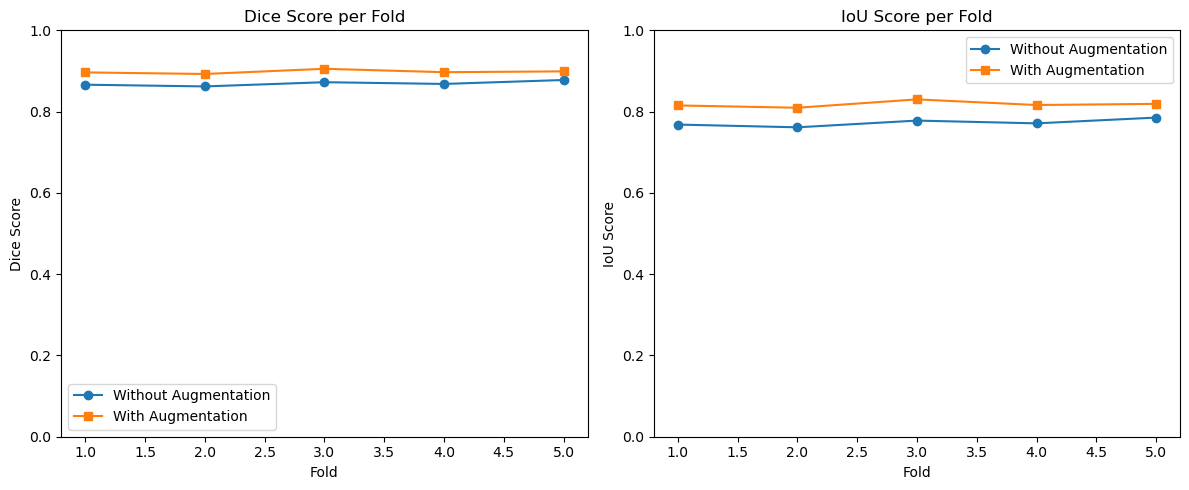

In [166]:
folds = list(range(1, 6))

plt.figure(figsize=(12, 5))

# Dice Scores
plt.subplot(1, 2, 1)
plt.plot(folds, noaug_dice, marker='o', label='Without Augmentation')
plt.plot(folds, aug_dice, marker='s', label='With Augmentation')
plt.title('Dice Score per Fold')
plt.xlabel('Fold')
plt.ylabel('Dice Score')
plt.ylim(0, 1)
plt.legend()

# IoU Scores
plt.subplot(1, 2, 2)
plt.plot(folds, noaug_iou, marker='o', label='Without Augmentation')
plt.plot(folds, aug_iou, marker='s', label='With Augmentation')
plt.title('IoU Score per Fold')
plt.xlabel('Fold')
plt.ylabel('IoU Score')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()